<center><h1>Crosswalk detection</h1></center>

# Importing

In [20]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [21]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import cv2
from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm import tqdm
from random import randrange
from sklearn.metrics import precision_score, recall_score

# Dataset

In the code below, it can be seen that this dataset contains 3434 images captured by a camera mounted on a vehicle. This dataset can be found at this [github repo](https://github.com/zhangzhengde0225/CDNet/blob/master/README.md). The dataset was split into a 10:90 ratio for training and testing, resulting in 3080 images for training and 354 for testing. There are no images with missing labels, and vice versa.

Train image count: 3080
Test image count: 354


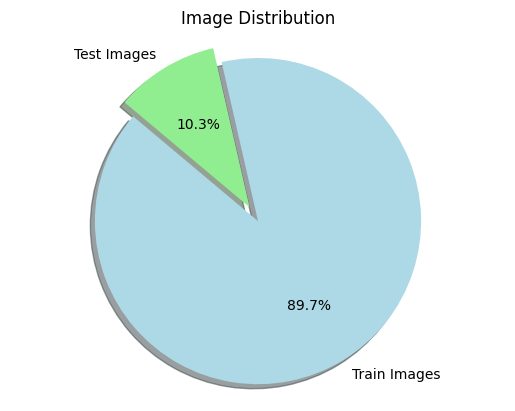

In [22]:
def count_images(data_dir):
    train_images_dir = os.path.join(data_dir, 'images/train')
    test_images_dir = os.path.join(data_dir, 'images/test')

    train_image_count = len([file for file in os.listdir(train_images_dir) if file.endswith('.jpg')])
    test_image_count = len([file for file in os.listdir(test_images_dir) if file.endswith('.jpg')])

    return train_image_count, test_image_count

def plot_image_distribution(train_image_count, test_image_count):
    labels = ['Train Images', 'Test Images']
    sizes = [train_image_count, test_image_count]
    colors = ['lightblue', 'lightgreen']
    explode = (0.1, 0)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title('Image Distribution')
    plt.show()

data_dir = '/kaggle/input/zebra-crossing-dataset/'
train_image_count, test_image_count = count_images(data_dir)
print(f"""Train image count: {train_image_count}\nTest image count: {test_image_count}""")
plot_image_distribution(train_image_count, test_image_count)

In [23]:
def find_missing_files():
    train_images_no_labels = []
    train_labels_no_images = []
    test_images_no_labels = []
    test_labels_no_images = []

    data_dir = '/kaggle/input/zebra-crossing-dataset/'

    def find_missing(data_dir, images_dir, labels_dir, images_no_labels, labels_no_images):
        image_files = set([os.path.splitext(file)[0] for file in os.listdir(os.path.join(data_dir, images_dir))])
        label_files = set([os.path.splitext(file)[0] for file in os.listdir(os.path.join(data_dir, labels_dir))])

        images_no_labels.extend(sorted(list(image_files - label_files)))

        labels_no_images.extend(sorted(list(label_files - image_files)))

    train_images_dir = os.path.join(data_dir, 'images/train')
    train_labels_dir = os.path.join(data_dir, 'labels/train')
    find_missing(data_dir, train_images_dir, train_labels_dir, train_images_no_labels, train_labels_no_images)

    test_images_dir = os.path.join(data_dir, 'images/test')
    test_labels_dir = os.path.join(data_dir, 'labels/test')
    find_missing(data_dir, test_images_dir, test_labels_dir, test_images_no_labels, test_labels_no_images)

    return train_images_no_labels, train_labels_no_images, test_images_no_labels, test_labels_no_images

train_images_no_labels, train_labels_no_images, test_images_no_labels, test_labels_no_images = find_missing_files()
print(f"""Train images with no labels: {train_images_no_labels}
        \nTrain labels with no images: {train_labels_no_images}
        \nTest images with no labels: {test_images_no_labels}
        \nTest labels with no images: {test_labels_no_images}""")

Train images with no labels: []
        
Train labels with no images: []
        
Test images with no labels: []
        
Test labels with no images: []


In [24]:
class ZebraCrossingDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))
        self.label_files = sorted(os.listdir(labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
        img_res = img_res / 255.0
        
        boxes = []
        labels = []
        
        h, w, _ = img_res.shape
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                label = int(parts[0]) + 1
                x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])
                x_center, y_center, bbox_width, bbox_height = x_center * w, y_center * h, bbox_width * w, bbox_height * h
                
                x1, y1 = int(x_center - bbox_width / 2), int(y_center - bbox_height / 2)
                x2, y2 = int(x_center + bbox_width / 2), int(y_center + bbox_height / 2)
                
                boxes.append([x1, y1, x2, y2])
                labels.append(label)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform:
            sample = self.transform(img=img_res, bboxes=target['boxes'], labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        return torch.tensor(img_res, dtype=torch.float32).permute(2, 0, 1), target

def collate_fn(batch):
    return tuple(zip(*batch))


train_images_dir = '/kaggle/input/zebra-crossing-dataset/images/train'
train_labels_dir = '/kaggle/input/zebra-crossing-dataset/labels/train'
test_images_dir = '/kaggle/input/zebra-crossing-dataset/images/test'
test_labels_dir = '/kaggle/input/zebra-crossing-dataset/labels/test'

train_dataset = ZebraCrossingDataset(train_images_dir, train_labels_dir)
test_dataset = ZebraCrossingDataset(test_images_dir, test_labels_dir)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, collate_fn=collate_fn)

img, target = train_dataset[1]
print(img.shape, '\n',target)

torch.Size([3, 224, 224]) 
 {'boxes': tensor([[123., 125., 150., 133.]]), 'labels': tensor([1]), 'image_id': 1, 'area': tensor([216.]), 'iscrowd': tensor([0])}


xmin: 23     ymin: 142     txmax: 129     ymax: 150
xmin: 38     ymin: 143     txmax: 87     ymax: 151
xmin: 2     ymin: 154     txmax: 186     ymax: 197
xmin: 47     ymin: 147     txmax: 177     ymax: 167
xmin: 123     ymin: 125     txmax: 151     ymax: 136
xmin: 1     ymin: 158     txmax: 223     ymax: 224
xmin: 0     ymin: 158     txmax: 158     ymax: 207
xmin: 139     ymin: 125     txmax: 170     ymax: 140
xmin: 107     ymin: 144     txmax: 117     ymax: 154


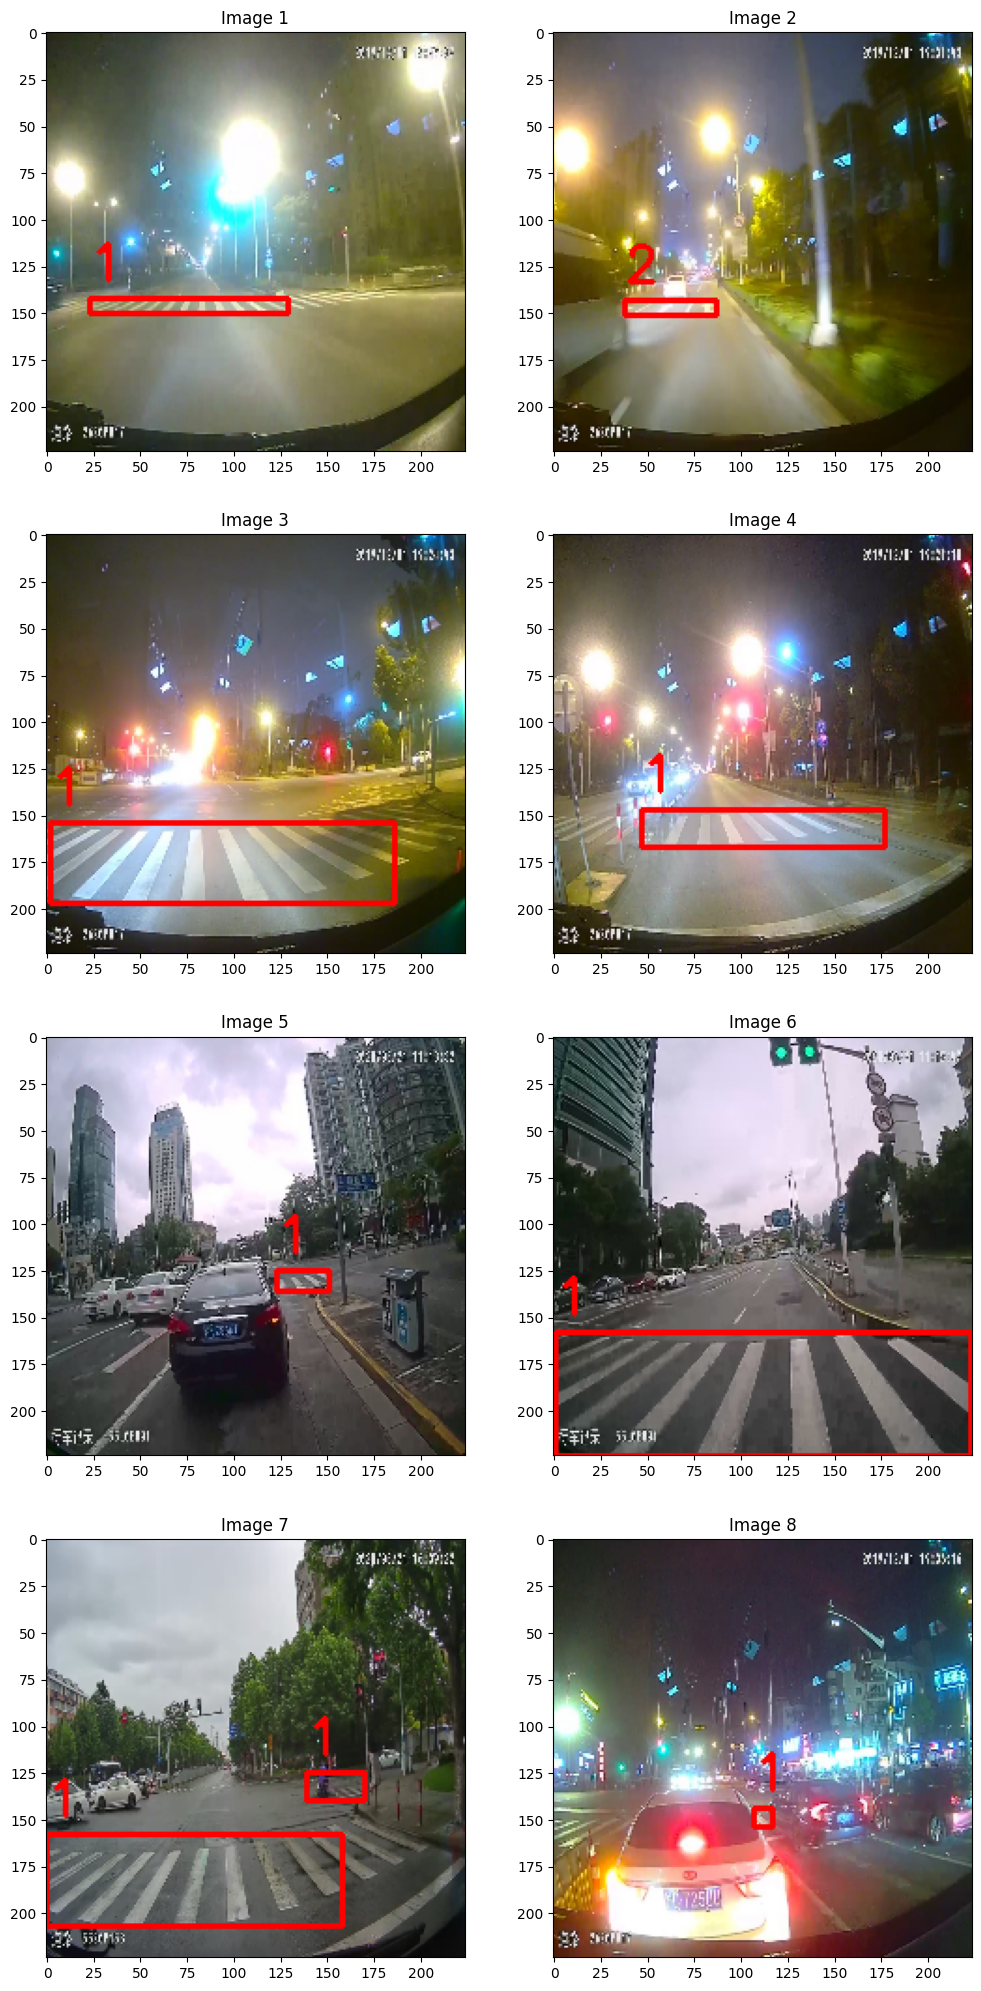

In [25]:
def display_images_with_bboxes(dataset, num_images=8):
    c = 2
    r = int(num_images / c)    
    
    plt.figure(figsize=(12, 25))
    for i in range(num_images):
        img_res, target = dataset[randrange(3080)]
        image = (img_res * 255).byte().permute(1, 2, 0).numpy()
        h, w, _ = image.shape
        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()
        
        for j, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = map(int, box)
            class_id = labels[j]
            print(f"xmin: {xmin}     ymin: {ymin}     txmax: {xmax}     ymax: {ymax}")
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(image, str(class_id), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
        plt.subplot(r, c, i + 1)
        plt.imshow(image)
        plt.title(f"Image {i + 1}")
    
    plt.show()

display_images_with_bboxes(train_dataset)

# Faster R-CNN model

Faster R-CNN model with a ResNet-50-FPN backbone from the [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497) paper. 

In [26]:
def calculate_precision_recall(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            processed_targets = []
            for t in targets:
                processed_target = {}
                for k, v in t.items():
                    if isinstance(v, torch.Tensor):
                        processed_target[k] = v.to(device)
                    else:
                        processed_target[k] = v
                processed_targets.append(processed_target)
            predictions = model(images)
            all_predictions.extend(predictions)
            all_targets.extend(processed_targets)
    
    pred_labels_flat = []
    true_labels_flat = []

    for preds, targets in zip(all_predictions, all_targets):
        if preds['labels'].nelement() == 0:
            pred_labels_thresh = [0] 
        else:
            pred_labels = preds['labels'].cpu().numpy()
            pred_labels_thresh = pred_labels.tolist()

        true_labels = targets['labels'].cpu().numpy().tolist()

        if len(pred_labels_thresh) < len(true_labels):
            pred_labels_thresh.extend([0] * (len(true_labels) - len(pred_labels_thresh)))
        elif len(pred_labels_thresh) > len(true_labels):
            pred_labels_thresh = pred_labels_thresh[:len(true_labels)]

        pred_labels_flat.extend(pred_labels_thresh)
        true_labels_flat.extend(true_labels)

    if len(pred_labels_flat) == 0 or len(true_labels_flat) == 0:
        return 0.0, 0.0

    precision = precision_score(true_labels_flat, pred_labels_flat, average='macro')
    recall = recall_score(true_labels_flat, pred_labels_flat, average='macro')

    return precision, recall

There are 3 classes:
- 0 - background
- 1 - crosswalk
- 2 - guide arrows

Epoch: [0]  [  0/616]  eta: 0:10:56  lr: 0.000013  loss: 1.6682 (1.6682)  loss_classifier: 1.2584 (1.2584)  loss_box_reg: 0.0321 (0.0321)  loss_objectness: 0.2696 (0.2696)  loss_rpn_box_reg: 0.1081 (0.1081)  time: 1.0656  data: 0.0886  max mem: 4662
Epoch: [0]  [ 10/616]  eta: 0:10:37  lr: 0.000094  loss: 1.5234 (1.4560)  loss_classifier: 1.1793 (1.1220)  loss_box_reg: 0.0252 (0.0295)  loss_objectness: 0.2236 (0.2503)  loss_rpn_box_reg: 0.0488 (0.0542)  time: 1.0524  data: 0.0883  max mem: 4820
Epoch: [0]  [ 20/616]  eta: 0:10:36  lr: 0.000176  loss: 1.1636 (1.0506)  loss_classifier: 0.7259 (0.7632)  loss_box_reg: 0.0252 (0.0310)  loss_objectness: 0.1798 (0.2063)  loss_rpn_box_reg: 0.0374 (0.0501)  time: 1.0680  data: 0.0890  max mem: 4821
Epoch: [0]  [ 30/616]  eta: 0:10:31  lr: 0.000257  loss: 0.3800 (0.7982)  loss_classifier: 0.1174 (0.5450)  loss_box_reg: 0.0432 (0.0373)  loss_objectness: 0.0874 (0.1665)  loss_rpn_box_reg: 0.0342 (0.0494)  time: 1.0919  data: 0.0886  max mem: 4821


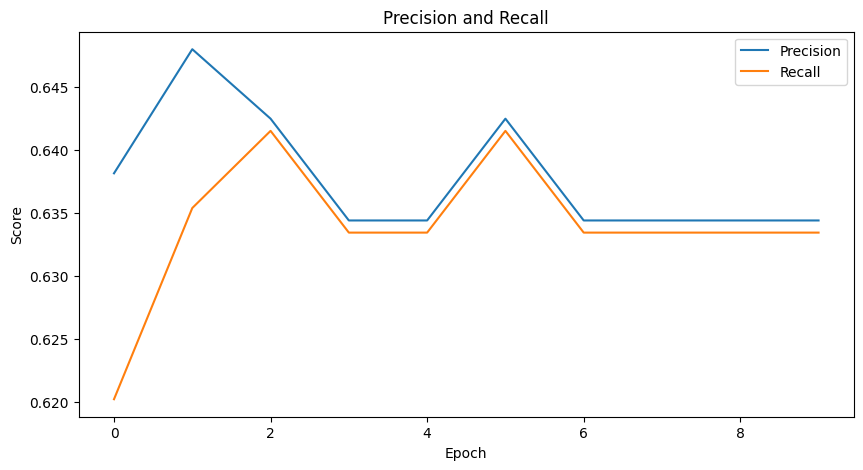

In [27]:
num_classes = 3

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

train_losses = []
test_losses = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    
    lr_scheduler.step()
    
    evaluate(model, test_loader, device=device)
    
    precision, recall = calculate_precision_recall(model, test_loader, device)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision and Recall')
plt.legend()
plt.show()

In [28]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Results

In [29]:
def apply_nms(original_prediction, iou_threshold=0.3):
    if original_prediction['boxes'].is_cuda:
        original_prediction['boxes'] = original_prediction['boxes'].cpu()
    if original_prediction['scores'].is_cuda:
        original_prediction['scores'] = original_prediction['scores'].cpu()
    if original_prediction['labels'].is_cuda:
        original_prediction['labels'] = original_prediction['labels'].cpu()

    keep = torchvision.ops.nms(original_prediction['boxes'], original_prediction['scores'], iou_threshold)
    
    final_prediction = {
        'boxes': original_prediction['boxes'][keep],
        'scores': original_prediction['scores'][keep],
        'labels': original_prediction['labels'][keep]
    }
    
    return final_prediction

prediction: {'boxes': tensor([[  9.1047, 151.8942, 217.1365, 197.9404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}


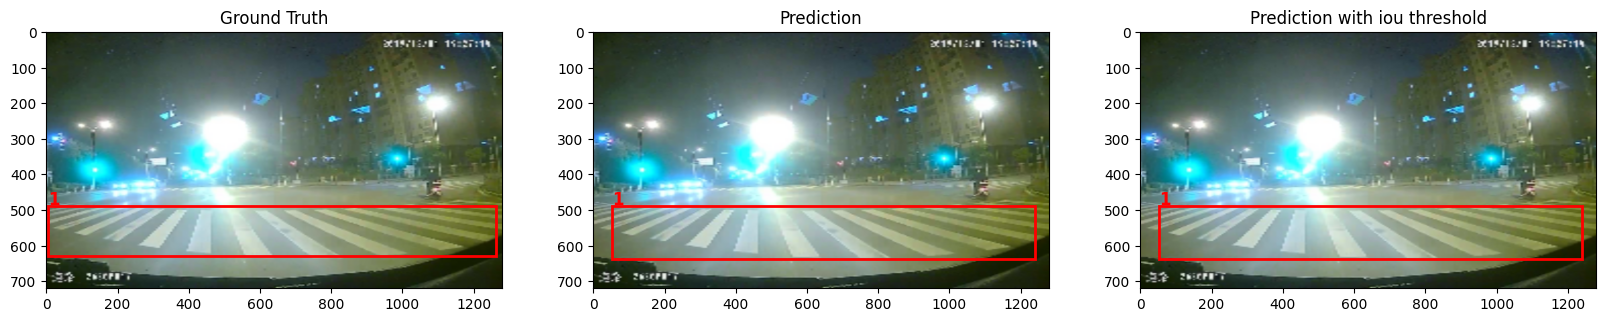

prediction: {'boxes': tensor([[  2.4714, 156.8764, 176.8490, 206.3259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}


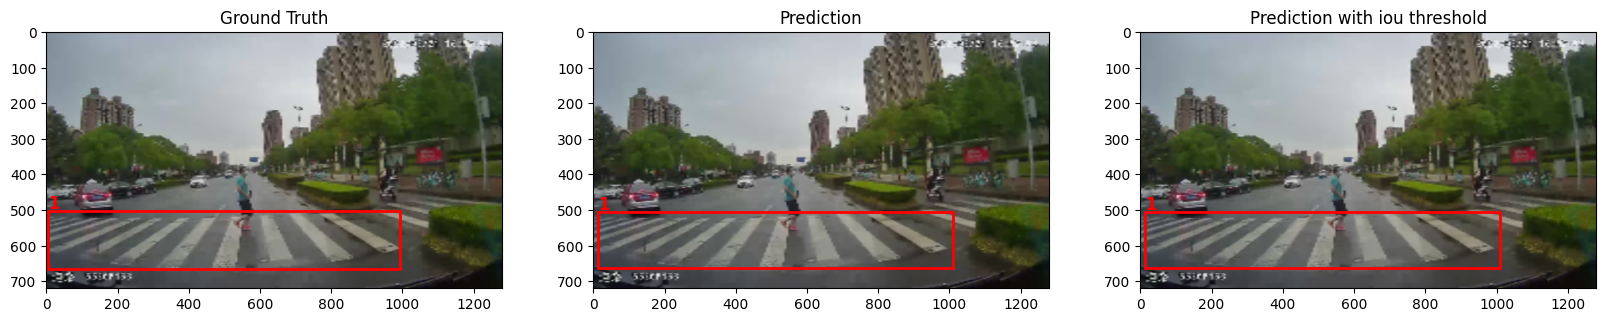

prediction: {'boxes': tensor([[ 49.9180, 142.0939, 108.6067, 148.7456],
        [ 50.8329, 140.3228, 142.6565, 148.7517]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1267], device='cuda:0')}


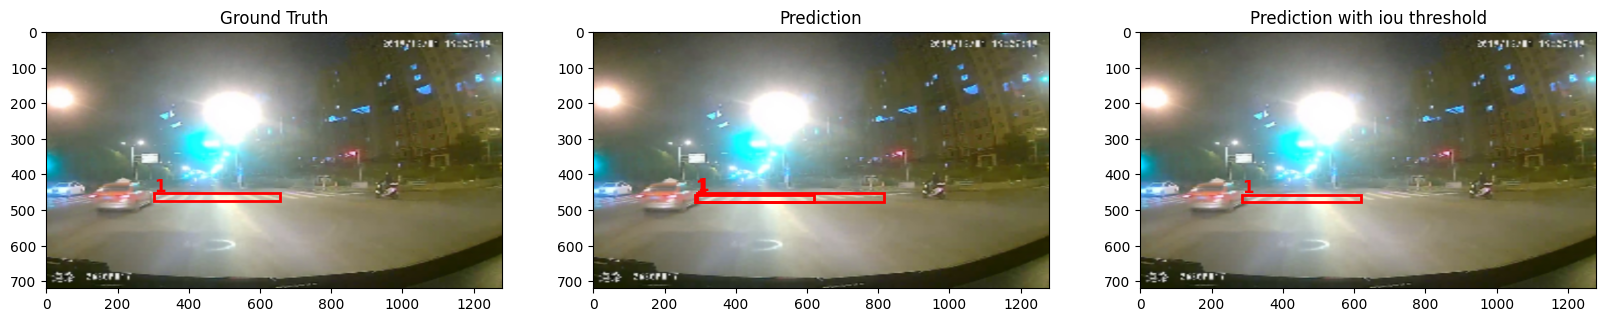

prediction: {'boxes': tensor([[ 27.8806, 146.2677,  93.9564, 160.9684]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}


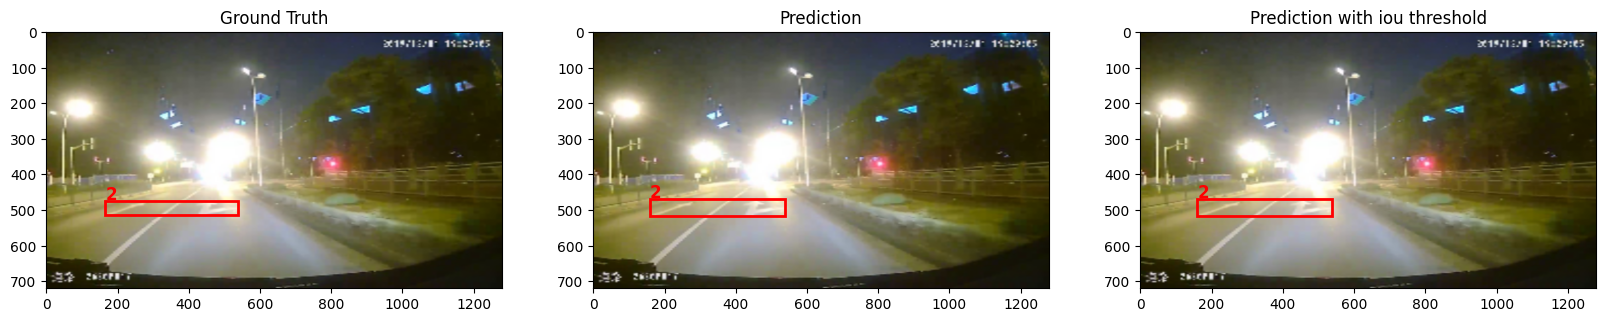

In [34]:
def plot_img_bbox(img, target, prediction, original_size=(1280, 720), resized_size=(224, 224)):
    img = img.permute(1, 2, 0).numpy()
    img = cv2.resize(img, original_size, interpolation=cv2.INTER_LINEAR)
    
    scale_x = original_size[0] / resized_size[0]
    scale_y = original_size[1] / resized_size[1]
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    
    ax[0].imshow(img)
    for i, box in enumerate(target['boxes']):
        x, y, width, height = box[0].item() * scale_x, box[1].item() * scale_y, (box[2].item() - box[0].item()) * scale_x, (box[3].item() - box[1].item()) * scale_y
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(x, y - 5, f"{int(target['labels'][i])}", color='r', fontsize=12, weight='bold')
    ax[0].set_title("Ground Truth")
    
    ax[1].imshow(img)
    for i, box in enumerate(prediction['boxes'].cpu()):
        x, y, width, height = box[0].item() * scale_x, box[1].item() * scale_y, (box[2].item() - box[0].item()) * scale_x, (box[3].item() - box[1].item()) * scale_y
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        if i < len(prediction['labels']):
            ax[1].text(x, y - 5, f"{int(prediction['labels'][i])}", color='r', fontsize=12, weight='bold')
    ax[1].set_title("Prediction")
    
    ax[2].imshow(img)
    nms_prediction = apply_nms(prediction, iou_threshold=0.3)
    for i, box in enumerate(nms_prediction['boxes']):
        x, y, width, height = box[0].item() * scale_x, box[1].item() * scale_y, (box[2].item() - box[0].item()) * scale_x, (box[3].item() - box[1].item()) * scale_y
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)
        if i < len(nms_prediction['labels']):
            ax[2].text(x, y - 5, f"{int(nms_prediction['labels'][i])}", color='r', fontsize=12, weight='bold')
    ax[2].set_title("Prediction with iou threshold")
    
    plt.show()

def display_expected_predicted_output(dataset, model, device, num_images=4):    
    rand_list = []
    model.eval()
    for i in range(num_images):
        rand_num = randrange(len(dataset))
        if rand_num not in rand_list:
            rand_list.append(rand_num)
            
            img, target = dataset[rand_num]

            with torch.no_grad():
                prediction = model([img.to(device)])[0]
                print(f"prediction: {prediction}")

            plot_img_bbox(img, target, prediction)

display_expected_predicted_output(test_dataset, model, device, num_images=4)